In [53]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [54]:
watermark -iv

pandas             : 1.5.3
keras              : 2.10.0
numpy              : 1.26.4
seaborn            : 0.13.2
sklearn            : 1.4.1.post1
tensorflow_datasets: 4.9.2
matplotlib         : 3.7.1
PIL                : 9.4.0
tensorflow         : 2.5.0



In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.applications as models
import tensorflow_datasets as tfds

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
"""
# 98 MB
resnet = models.resnet50.ResNet50(weights='imagenet', include_top=False)
# 528MB
vgg16 = models.vgg16.VGG16(weights='imagenet', include_top=False)
# 23MB
nnm = models.NASNetMobile(weights='imagenet', include_top=False)
"""

"\n# 98 MB\nresnet = models.resnet50.ResNet50(weights='imagenet', include_top=False)\n# 528MB\nvgg16 = models.vgg16.VGG16(weights='imagenet', include_top=False)\n# 23MB\nnnm = models.NASNetMobile(weights='imagenet', include_top=False)\n"

In [25]:
effnet = keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False)
effnet.summary()

24274472/24274472 [==============================] - 4s 0us/step
Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_10 (Rescaling)       (None, None, None,   0           ['input_6[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_5 (Normalization  (None, None, None,   0          ['rescaling_10[0][0]']           
 )               

In [26]:
effnet = keras.applications.EfficientNetV2B0(weights='imagenet', include_top=True)
effnet.summary()

29403144/29403144 [==============================] - 4s 0us/step
Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_11 (Rescaling)       (None, 224, 224, 3)  0           ['input_7[0][0]']                
                                                                                                  
 normalization_6 (Normalization  (None, 224, 224, 3)  0          ['rescaling_11[0][0]']           
 )                                                                                                
                 

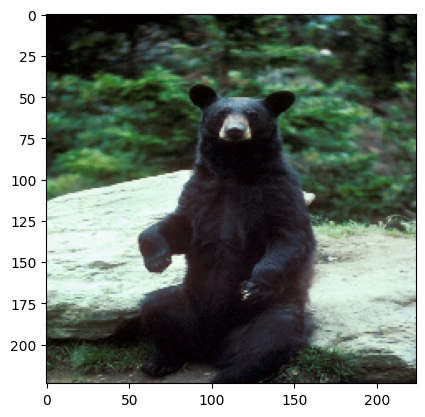

In [5]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.vgg16 import preprocess_input

import urllib.request
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Public domain image
url = 'https://upload.wikimedia.org/wikipedia/commons/0/02/Black_bear_large.jpg'
urllib.request.urlretrieve(url, 'bear.jpg')

file = image.load_img('bear.jpg', target_size=(224, 224))
plt.imshow(file)

In [6]:
img = image.img_to_array(file)
img = np.expand_dims(img, 0)
img_preprocessed = preprocess_input(img)
print(img.shape)

(1, 224, 224, 3)


In [7]:
pred = effnet.predict(img)

1/1 [==============================] - 28s 28s/step


In [8]:
pred.shape

(1, 1000)

In [9]:
print(keras.applications.imagenet_utils.decode_predictions(pred))

35363/35363 [==============================] - 0s 2us/step
[[('n01496331', 'electric_ray', 0.036324102), ('n02074367', 'dugong', 0.026573284), ('n01498041', 'stingray', 0.017018368), ('n04589890', 'window_screen', 0.01679551), ('n02606052', 'rock_beauty', 0.013264215)]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


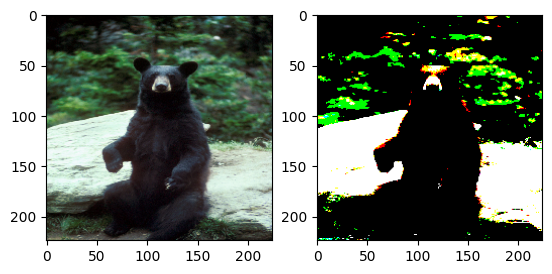

In [10]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(np.squeeze(file))
ax[1].imshow(np.squeeze(img_preprocessed))

In [11]:
pred = effnet.predict(img_preprocessed)
print(keras.applications.imagenet_utils.decode_predictions(pred))

1/1 [==============================] - 0s 40ms/step
[[('n04589890', 'window_screen', 0.019585693), ('n01496331', 'electric_ray', 0.019103412), ('n02114548', 'white_wolf', 0.015991192), ('n09472597', 'volcano', 0.011588468), ('n01873310', 'platypus', 0.0109903375)]]


1/1 [==============================] - 0s 110ms/step


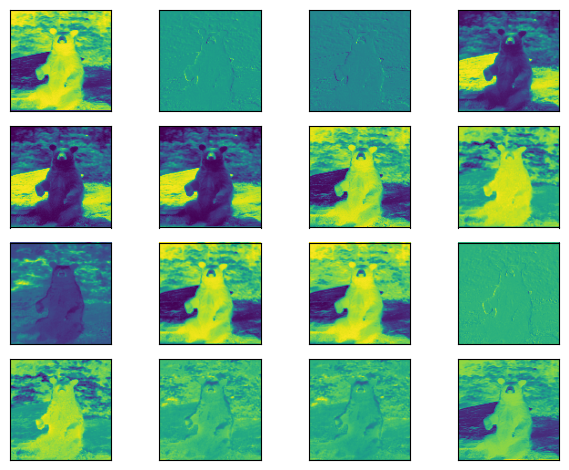

In [12]:
model = keras.Model(inputs=effnet.inputs, outputs=effnet.layers[6].output)
feature_maps = model.predict(img_preprocessed)

ix = 1
for _ in range(4):
    for _ in range(4):
        # specify subplot and turn of axis
        ax = plt.subplot(4, 4, ix)
        ax.imshow(feature_maps[0, :, :, ix-1])
        ax.set_xticks([])
        ax.set_yticks([])
        ix += 1
        
plt.tight_layout()
plt.show()

In [27]:
# Load without top
# When adding new layers, we also need to define the input_shape
effnet_base = keras.applications.EfficientNetV2B0(weights='imagenet', 
                                          include_top=False, 
                                          input_shape=((224, 224, 3)))

# Or load the full model
full_effnet = keras.applications.EfficientNetV2B0(weights='imagenet', 
                                            include_top=True, 
                                            input_shape=((224, 224, 3)))
                                            
# And then remove X layers from the top
trimmed_effnet = keras.Model(inputs=full_effnet.input, outputs=full_effnet.layers[-3].output)

In [28]:
# When adding new layers, we also need to define the input_shape
effnet_base = keras.applications.EfficientNetV2B0(weights='imagenet', 
                                          include_top=False, 
                                          input_shape=((224, 224, 3)))

effnet_base.trainable = False

In [29]:
gap = keras.layers.GlobalAveragePooling2D()(effnet_base.output, training=False)
do = keras.layers.Dropout(0.2)(gap)
output = keras.layers.Dense(100, activation='softmax')(do)

new_model = keras.Model(inputs=effnet_base.input, outputs=output)

In [30]:
for index, layer in enumerate(new_model.layers):
    print("Layer: {}, Trainable: {}".format(index, layer.trainable))

Layer: 0, Trainable: False
Layer: 1, Trainable: False
Layer: 2, Trainable: False
Layer: 3, Trainable: False
Layer: 4, Trainable: False
Layer: 5, Trainable: False
Layer: 6, Trainable: False
Layer: 7, Trainable: False
Layer: 8, Trainable: False
Layer: 9, Trainable: False
Layer: 10, Trainable: False
Layer: 11, Trainable: False
Layer: 12, Trainable: False
Layer: 13, Trainable: False
Layer: 14, Trainable: False
Layer: 15, Trainable: False
Layer: 16, Trainable: False
Layer: 17, Trainable: False
Layer: 18, Trainable: False
Layer: 19, Trainable: False
Layer: 20, Trainable: False
Layer: 21, Trainable: False
Layer: 22, Trainable: False
Layer: 23, Trainable: False
Layer: 24, Trainable: False
Layer: 25, Trainable: False
Layer: 26, Trainable: False
Layer: 27, Trainable: False
Layer: 28, Trainable: False
Layer: 29, Trainable: False
Layer: 30, Trainable: False
Layer: 31, Trainable: False
Layer: 32, Trainable: False
Layer: 33, Trainable: False
Layer: 34, Trainable: False
Layer: 35, Trainable: False
La

In [17]:
(test_set, valid_set, train_set), info = tfds.load("cifar100", 
                                           split=["test", "train[0%:20%]", "train[20%:]"],
                                           as_supervised=True, with_info=True)

class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
print(f'Class names: {class_names[:10]}...', ) # ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle']...
print('Num of classes:', n_classes) # Num of classes: 100

print("Train set size:", len(train_set)) # Train set size: 37500
print("Test set size:", len(test_set)) # Test set size: 5000
print("Valid set size:", len(valid_set)) # Valid set size: 7500

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Denys\tensorflow_datasets\cifar100\3.0.2.incompleteSZTO3I\cifar100-train.tfrecord*...:   0%…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Denys\tensorflow_datasets\cifar100\3.0.2.incompleteSZTO3I\cifar100-test.tfrecord*...:   0%|…

Dataset cifar100 downloaded and prepared to C:\Users\Denys\tensorflow_datasets\cifar100\3.0.2. Subsequent calls will reuse this data.
Class names: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle']...
Num of classes: 100
Train set size: 40000
Test set size: 10000
Valid set size: 10000


In [18]:
config = {
    'TRAIN_SIZE' : len(train_set),
    'BATCH_SIZE' : 32
}

In [19]:
def preprocess_image(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    img = tf.image.random_flip_left_right(resized_image)
    img = tf.image.random_brightness(img, 0.4)
    # Preprocess image with model-specific function if it has one
    # processed_image = preprocess_input(resized_image)
    return img, label

In [20]:
def preprocess_test_valid(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    # Preprocess image with model-specific function if it has one
    # processed_image = preprocess_input(resized_image)
    return resized_image, label

In [21]:
train_set = train_set.map(preprocess_image).batch(32).repeat().prefetch(tf.data.AUTOTUNE)
test_set = test_set.map(preprocess_test_valid).batch(32).prefetch(tf.data.AUTOTUNE)
valid_set = valid_set.map(preprocess_test_valid).batch(32).prefetch(tf.data.AUTOTUNE)

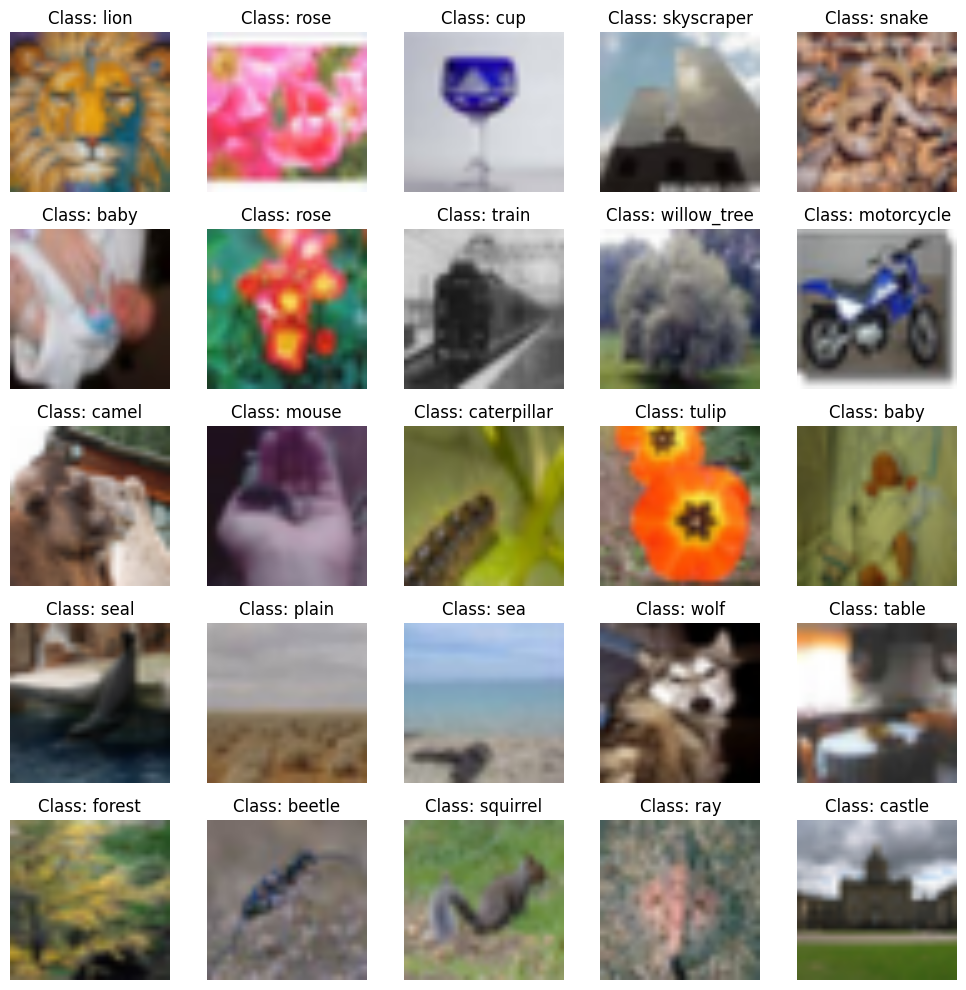

In [22]:
fig = plt.figure(figsize=(10, 10))

i = 1
for entry in test_set.take(25):

    sample_image = np.squeeze(entry[0].numpy()[0])
    sample_label = class_names[entry[1].numpy()[0]]
    ax = fig.add_subplot(5, 5, i)
    
    ax.imshow(np.array(sample_image, np.int32))
    ax.set_title("Class: %s" % (sample_label))
    ax.axis('off')
    i = i+1

plt.tight_layout()
plt.show()

In [31]:
checkpoint = keras.callbacks.ModelCheckpoint(filepath='effnet_transfer_learning.h5', save_best_only=True)

new_model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=keras.optimizers.Adam(), 
                  metrics=["accuracy", keras.metrics.SparseTopKCategoricalAccuracy(k=3)])

new_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_14 (Rescaling)       (None, 224, 224, 3)  0           ['input_10[0][0]']               
                                                                                                  
 normalization_9 (Normalization  (None, 224, 224, 3)  0          ['rescaling_14[0][0]']           
 )                                                                                                
                                                                                            

In [32]:
history = new_model.fit(train_set, 
                        epochs=10,
                        steps_per_epoch = config['TRAIN_SIZE']/config['BATCH_SIZE'],
                        callbacks=[checkpoint],
                        validation_data=valid_set)

Epoch 1/10
1250/1250 [==============================] - 191s 145ms/step - loss: 1.5986 - accuracy: 0.5915 - sparse_top_k_categorical_accuracy: 0.7898 - val_loss: 1.0559 - val_accuracy: 0.6978 - val_sparse_top_k_categorical_accuracy: 0.8753
Epoch 2/10
1250/1250 [==============================] - 177s 142ms/step - loss: 1.0405 - accuracy: 0.7013 - sparse_top_k_categorical_accuracy: 0.8782 - val_loss: 0.9576 - val_accuracy: 0.7185 - val_sparse_top_k_categorical_accuracy: 0.8918
Epoch 3/10
1250/1250 [==============================] - 180s 144ms/step - loss: 0.9193 - accuracy: 0.7328 - sparse_top_k_categorical_accuracy: 0.8970 - val_loss: 0.9197 - val_accuracy: 0.7279 - val_sparse_top_k_categorical_accuracy: 0.8942
Epoch 4/10
1250/1250 [==============================] - 181s 145ms/step - loss: 0.8536 - accuracy: 0.7474 - sparse_top_k_categorical_accuracy: 0.9074 - val_loss: 0.9044 - val_accuracy: 0.7336 - val_sparse_top_k_categorical_accuracy: 0.8984
Epoch 5/10
1250/1250 [==================

In [33]:
new_model.evaluate(test_set)

313/313 [==============================] - 38s 118ms/step - loss: 0.8711 - accuracy: 0.7464 - sparse_top_k_categorical_accuracy: 0.9026


[0.8710777163505554, 0.746399998664856, 0.9025999903678894]

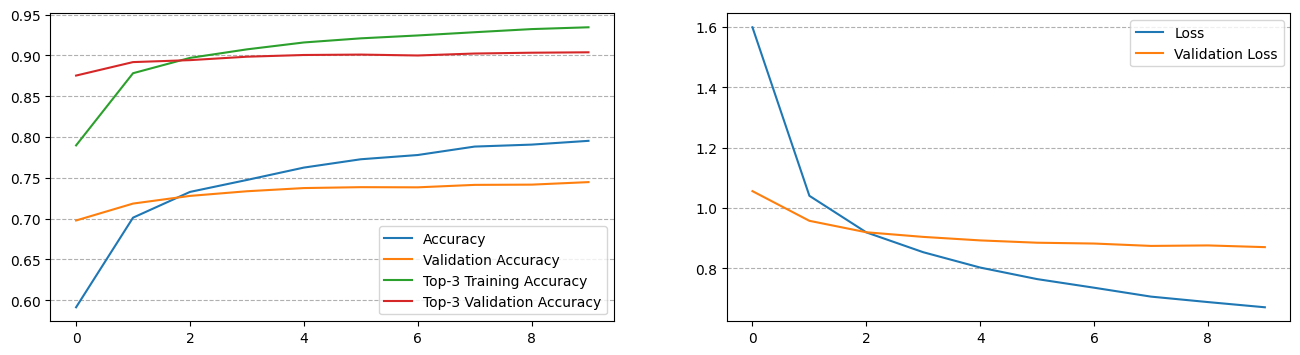

In [34]:
acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
top3_acc, valtop3_acc = history.history['sparse_top_k_categorical_accuracy'], history.history['val_sparse_top_k_categorical_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']


fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].plot(acc, label='Accuracy')
ax[0].plot(val_acc, label='Validation Accuracy')
ax[0].plot(top3_acc, label="Top-3 Training Accuracy")
ax[0].plot(valtop3_acc, label="Top-3 Validation Accuracy")
ax[0].grid(axis='y', linestyle='--')

ax[1].plot(loss, label='Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].grid(axis='y', linestyle='--')

ax[0].legend()
ax[1].legend()
plt.show()

In [35]:
y_pred = new_model.predict(test_set)
labels = tf.concat([y for x, y in test_set], axis=0)

313/313 [==============================] - 38s 109ms/step


In [37]:
from sklearn import metrics
print(metrics.classification_report(labels, np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.84      0.96      0.90       100
           1       0.89      0.82      0.85       100
           2       0.66      0.63      0.64       100
           3       0.60      0.70      0.65       100
           4       0.62      0.59      0.61       100
           5       0.73      0.69      0.71       100
           6       0.89      0.78      0.83       100
           7       0.67      0.85      0.75       100
           8       0.87      0.83      0.85       100
           9       0.91      0.91      0.91       100
          10       0.68      0.62      0.65       100
          11       0.49      0.49      0.49       100
          12       0.87      0.78      0.82       100
          13       0.80      0.70      0.74       100
          14       0.81      0.70      0.75       100
          15       0.83      0.82      0.82       100
          16       0.83      0.87      0.85       100
          17       0.88    

[Text(0, 0, 'apple'),
 Text(0, 1, 'aquarium_fish'),
 Text(0, 2, 'baby'),
 Text(0, 3, 'bear'),
 Text(0, 4, 'beaver'),
 Text(0, 5, 'bed'),
 Text(0, 6, 'bee'),
 Text(0, 7, 'beetle'),
 Text(0, 8, 'bicycle'),
 Text(0, 9, 'bottle'),
 Text(0, 10, 'bowl'),
 Text(0, 11, 'boy'),
 Text(0, 12, 'bridge'),
 Text(0, 13, 'bus'),
 Text(0, 14, 'butterfly'),
 Text(0, 15, 'camel'),
 Text(0, 16, 'can'),
 Text(0, 17, 'castle'),
 Text(0, 18, 'caterpillar'),
 Text(0, 19, 'cattle'),
 Text(0, 20, 'chair'),
 Text(0, 21, 'chimpanzee'),
 Text(0, 22, 'clock'),
 Text(0, 23, 'cloud'),
 Text(0, 24, 'cockroach'),
 Text(0, 25, 'couch'),
 Text(0, 26, 'crab'),
 Text(0, 27, 'crocodile'),
 Text(0, 28, 'cup'),
 Text(0, 29, 'dinosaur'),
 Text(0, 30, 'dolphin'),
 Text(0, 31, 'elephant'),
 Text(0, 32, 'flatfish'),
 Text(0, 33, 'forest'),
 Text(0, 34, 'fox'),
 Text(0, 35, 'girl'),
 Text(0, 36, 'hamster'),
 Text(0, 37, 'house'),
 Text(0, 38, 'kangaroo'),
 Text(0, 39, 'keyboard'),
 Text(0, 40, 'lamp'),
 Text(0, 41, 'lawn_mower'),


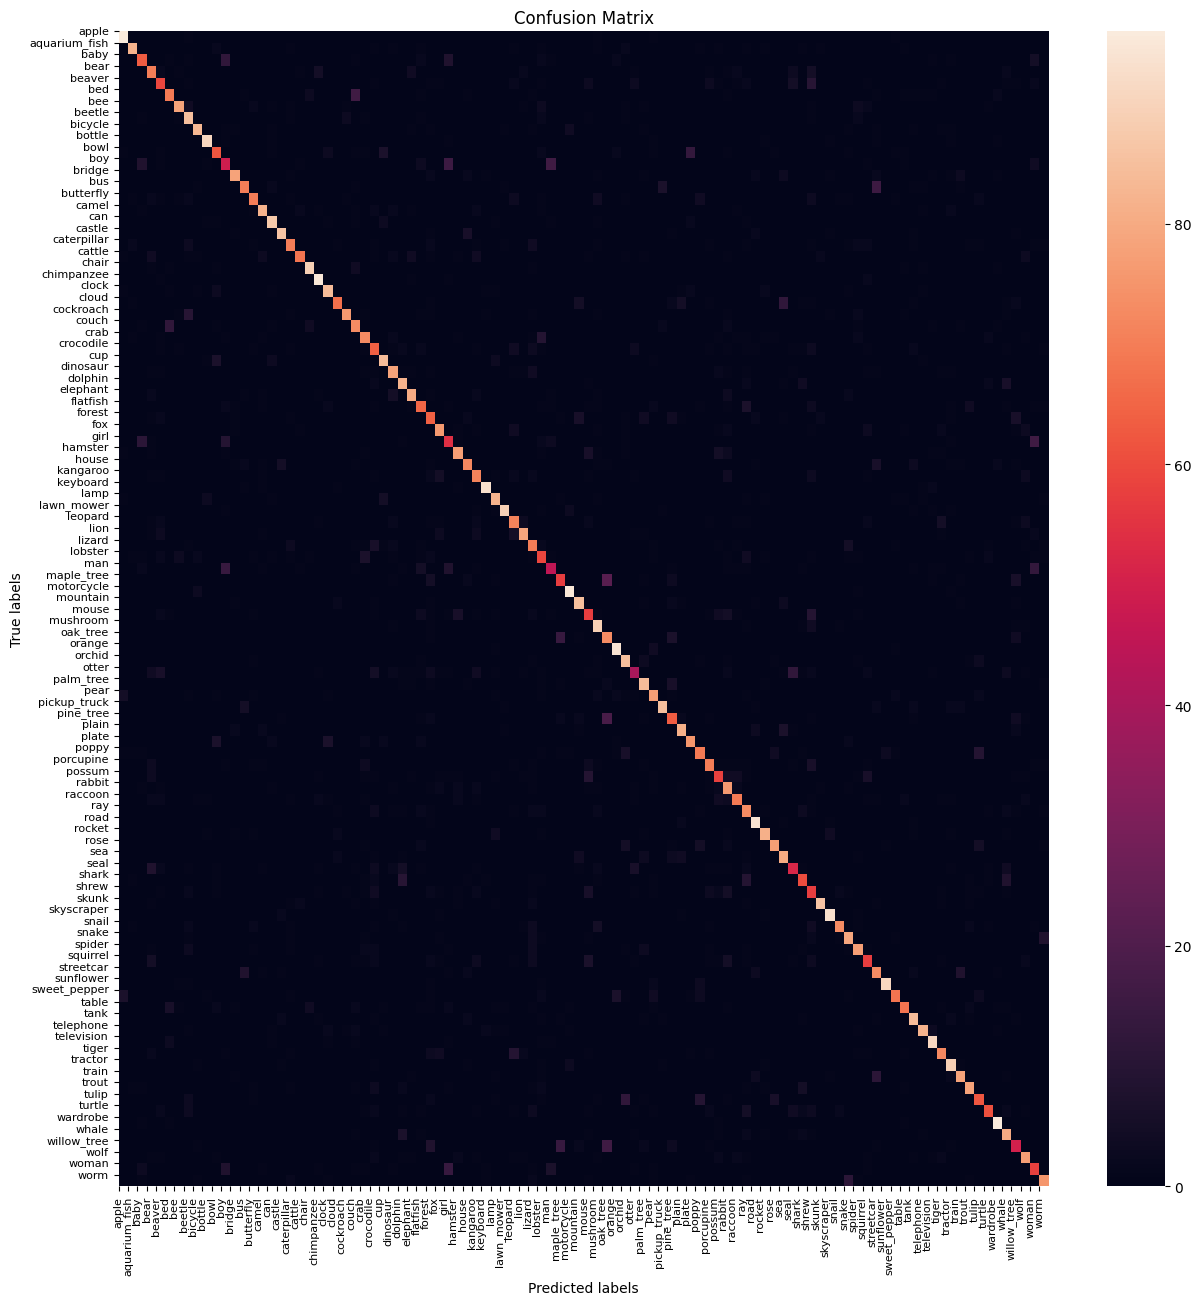

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix = confusion_matrix(labels, y_pred.argmax(axis=1))

# Plot on heatmap
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(matrix, ax=ax, fmt='g')

# Stylize heatmap
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Set ticks
ax.xaxis.set_ticks(np.arange(0, 100, 1))
ax.yaxis.set_ticks(np.arange(0, 100, 1))
ax.xaxis.set_ticklabels(class_names, rotation=90, fontsize=8)
ax.yaxis.set_ticklabels(class_names, rotation=0, fontsize=8)

In [40]:
new_model.save('effnet_transfer_learning.h5')
loaded_model = keras.models.load_model('effnet_transfer_learning.h5')

In [41]:
for layer in loaded_model.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

for index, layer in enumerate(loaded_model.layers):
    print("Layer: {}, Trainable: {}".format(index, layer.trainable))

Layer: 0, Trainable: True
Layer: 1, Trainable: True
Layer: 2, Trainable: True
Layer: 3, Trainable: True
Layer: 4, Trainable: False
Layer: 5, Trainable: True
Layer: 6, Trainable: True
Layer: 7, Trainable: False
Layer: 8, Trainable: True
Layer: 9, Trainable: True
Layer: 10, Trainable: False
Layer: 11, Trainable: True
Layer: 12, Trainable: True
Layer: 13, Trainable: False
Layer: 14, Trainable: True
Layer: 15, Trainable: False
Layer: 16, Trainable: True
Layer: 17, Trainable: True
Layer: 18, Trainable: False
Layer: 19, Trainable: True
Layer: 20, Trainable: True
Layer: 21, Trainable: True
Layer: 22, Trainable: False
Layer: 23, Trainable: True
Layer: 24, Trainable: True
Layer: 25, Trainable: False
Layer: 26, Trainable: True
Layer: 27, Trainable: False
Layer: 28, Trainable: True
Layer: 29, Trainable: True
Layer: 30, Trainable: False
Layer: 31, Trainable: True
Layer: 32, Trainable: True
Layer: 33, Trainable: True
Layer: 34, Trainable: False
Layer: 35, Trainable: True
Layer: 36, Trainable: True


In [42]:
checkpoint = keras.callbacks.ModelCheckpoint(filepath='effnet_transfer_learning_finetuned.h5', save_best_only=True)

# Recompile after turning to trainable
loaded_model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=keras.optimizers.Adam(learning_rate=3e-6, decay=(1e-6)), 
                  metrics=["accuracy", keras.metrics.SparseTopKCategoricalAccuracy(k=3)])

history = loaded_model.fit(train_set, 
                        epochs=15,
                        steps_per_epoch = config['TRAIN_SIZE']/config['BATCH_SIZE'],
                        callbacks=[checkpoint],
                        validation_data=valid_set)

Epoch 1/15
1250/1250 [==============================] - 644s 500ms/step - loss: 0.5261 - accuracy: 0.8364 - sparse_top_k_categorical_accuracy: 0.9563 - val_loss: 0.7118 - val_accuracy: 0.7868 - val_sparse_top_k_categorical_accuracy: 0.9327
Epoch 2/15
1250/1250 [==============================] - 614s 491ms/step - loss: 0.4698 - accuracy: 0.8553 - sparse_top_k_categorical_accuracy: 0.9634 - val_loss: 0.6805 - val_accuracy: 0.7957 - val_sparse_top_k_categorical_accuracy: 0.9370
Epoch 3/15
1250/1250 [==============================] - 620s 496ms/step - loss: 0.4449 - accuracy: 0.8614 - sparse_top_k_categorical_accuracy: 0.9664 - val_loss: 0.6619 - val_accuracy: 0.8019 - val_sparse_top_k_categorical_accuracy: 0.9394
Epoch 4/15
1250/1250 [==============================] - 622s 498ms/step - loss: 0.4226 - accuracy: 0.8675 - sparse_top_k_categorical_accuracy: 0.9685 - val_loss: 0.6491 - val_accuracy: 0.8051 - val_sparse_top_k_categorical_accuracy: 0.9408
Epoch 5/15
1250/1250 [==================

In [43]:
loaded_model.save('effnet_transfer_learning_finetuned.h5')

In [44]:
loaded_model.evaluate(test_set)

313/313 [==============================] - 35s 112ms/step - loss: 0.5983 - accuracy: 0.8214 - sparse_top_k_categorical_accuracy: 0.9499


[0.5982983112335205, 0.821399986743927, 0.9498999714851379]

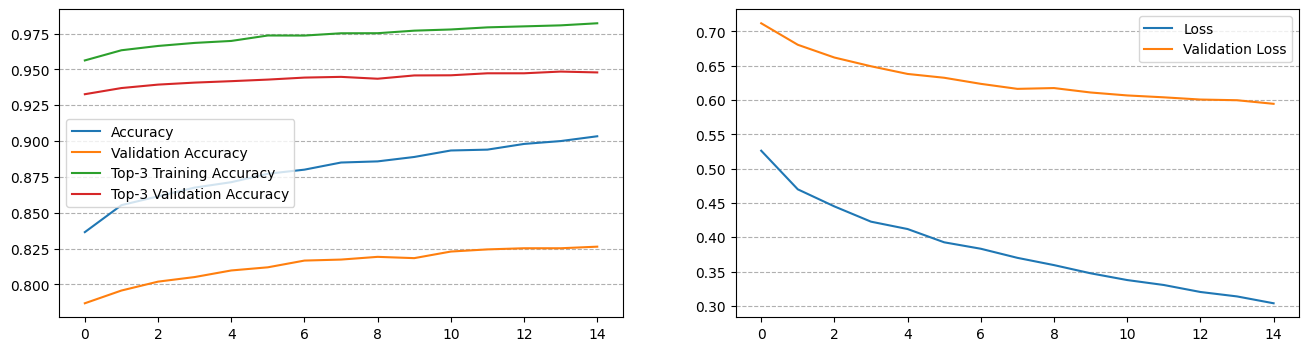

In [45]:
acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
top3_acc, valtop3_acc = history.history['sparse_top_k_categorical_accuracy'], history.history['val_sparse_top_k_categorical_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']


fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].plot(acc, label='Accuracy')
ax[0].plot(val_acc, label='Validation Accuracy')
ax[0].plot(top3_acc, label="Top-3 Training Accuracy")
ax[0].plot(valtop3_acc, label="Top-3 Validation Accuracy")
ax[0].grid(axis='y', linestyle='--')

ax[1].plot(loss, label='Loss')
ax[1].plot(val_loss, label='Validation Loss')
ax[1].grid(axis='y', linestyle='--')

ax[0].legend()
ax[1].legend()
plt.show()

1/1 [==============================] - 0s 41ms/step


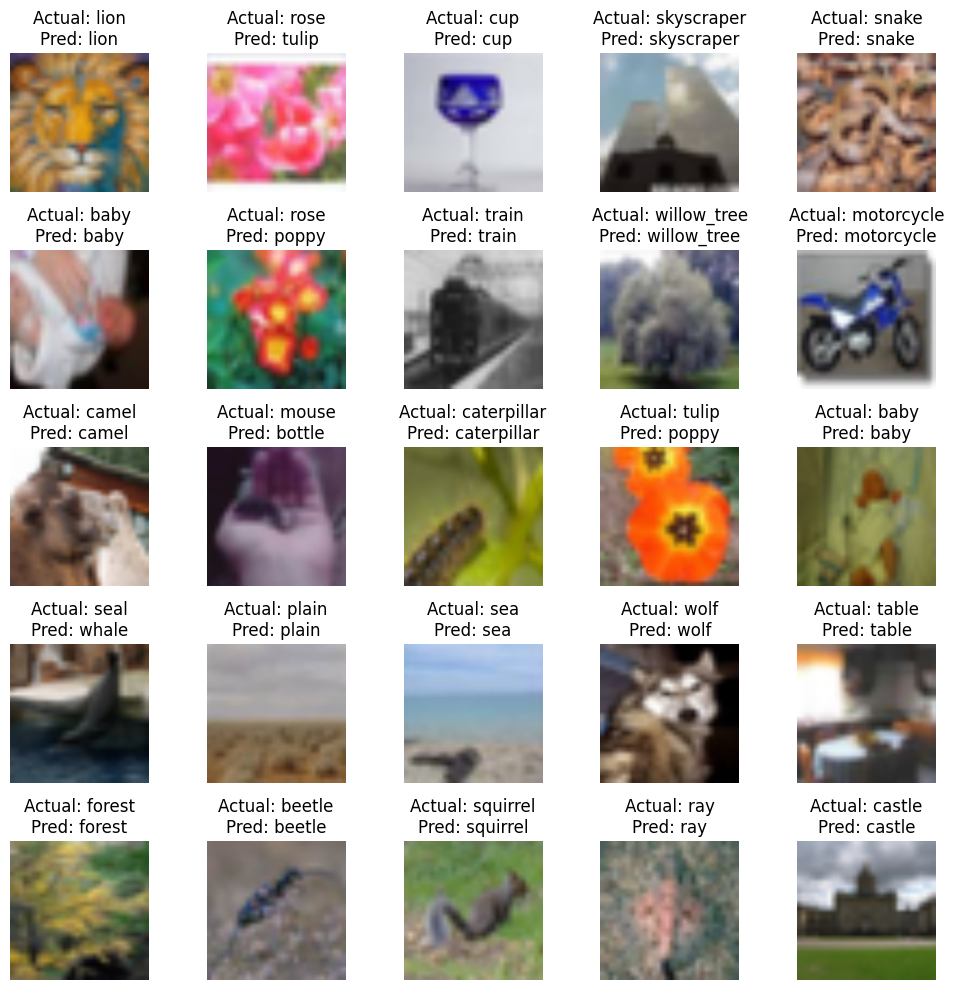

In [46]:
fig = plt.figure(figsize=(10, 10))

i = 1
for entry in test_set.take(25):
    # Predict, get the raw Numpy prediction probabilities
    # Reshape entry to the model's expected input shape
    pred = np.argmax(loaded_model.predict(entry[0].numpy()[0].reshape(1, 224, 224, 3)))

    # Get sample image as numpy array
    sample_image = entry[0].numpy()[0]
    # Get associated label
    sample_label = class_names[entry[1].numpy()[0]]
    # Get human label based on the prediction
    prediction_label = class_names[pred]
    ax = fig.add_subplot(5, 5, i)
    
    # Plot image and sample_label alongside prediction_label
    ax.imshow(np.array(sample_image, np.int32))
    ax.set_title("Actual: %s\nPred: %s" % (sample_label, prediction_label))
    ax.axis('off')
    i = i+1

plt.tight_layout()
plt.show()

In [47]:
y_pred = loaded_model.predict(test_set)
labels = tf.concat([y for x, y in test_set], axis=0)

313/313 [==============================] - 34s 103ms/step


[Text(0, 0, 'apple'),
 Text(0, 1, 'aquarium_fish'),
 Text(0, 2, 'baby'),
 Text(0, 3, 'bear'),
 Text(0, 4, 'beaver'),
 Text(0, 5, 'bed'),
 Text(0, 6, 'bee'),
 Text(0, 7, 'beetle'),
 Text(0, 8, 'bicycle'),
 Text(0, 9, 'bottle'),
 Text(0, 10, 'bowl'),
 Text(0, 11, 'boy'),
 Text(0, 12, 'bridge'),
 Text(0, 13, 'bus'),
 Text(0, 14, 'butterfly'),
 Text(0, 15, 'camel'),
 Text(0, 16, 'can'),
 Text(0, 17, 'castle'),
 Text(0, 18, 'caterpillar'),
 Text(0, 19, 'cattle'),
 Text(0, 20, 'chair'),
 Text(0, 21, 'chimpanzee'),
 Text(0, 22, 'clock'),
 Text(0, 23, 'cloud'),
 Text(0, 24, 'cockroach'),
 Text(0, 25, 'couch'),
 Text(0, 26, 'crab'),
 Text(0, 27, 'crocodile'),
 Text(0, 28, 'cup'),
 Text(0, 29, 'dinosaur'),
 Text(0, 30, 'dolphin'),
 Text(0, 31, 'elephant'),
 Text(0, 32, 'flatfish'),
 Text(0, 33, 'forest'),
 Text(0, 34, 'fox'),
 Text(0, 35, 'girl'),
 Text(0, 36, 'hamster'),
 Text(0, 37, 'house'),
 Text(0, 38, 'kangaroo'),
 Text(0, 39, 'keyboard'),
 Text(0, 40, 'lamp'),
 Text(0, 41, 'lawn_mower'),


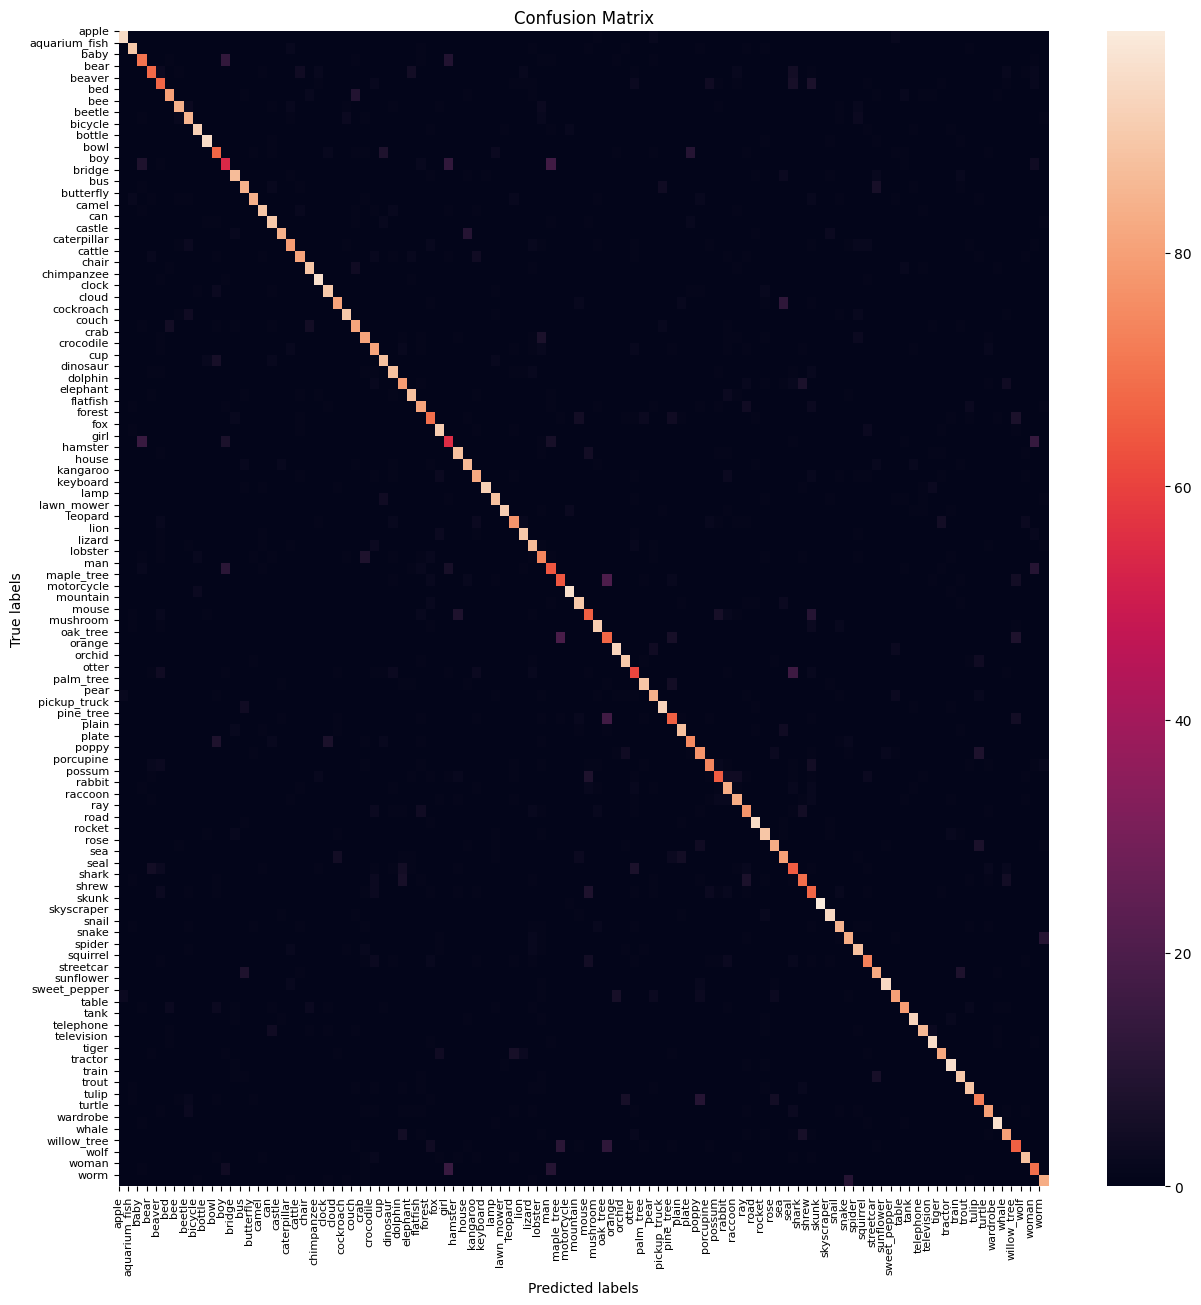

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix = confusion_matrix(labels, y_pred.argmax(axis=1))

# Plot on heatmap
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(matrix, ax=ax, fmt='g')

# Stylize heatmap
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

ax.xaxis.set_ticks(np.arange(0, 100, 1))
ax.yaxis.set_ticks(np.arange(0, 100, 1))

ax.xaxis.set_ticklabels(class_names, rotation=90, fontsize=8)
ax.yaxis.set_ticklabels(class_names, rotation=0, fontsize=8)

1/1 [==============================] - 2s 2s/step


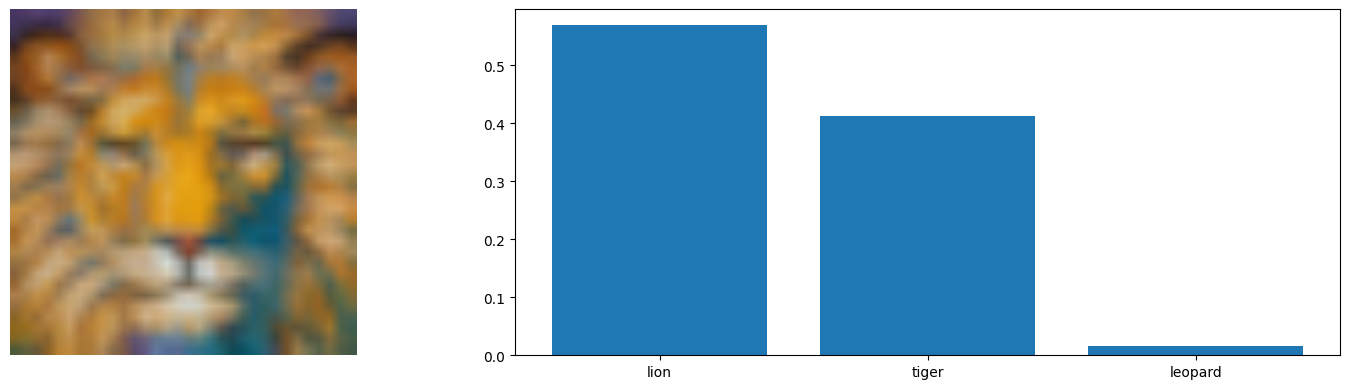

In [49]:
for entry in test_set.take(1):
    img = entry[0][0].numpy().astype('int')
    label = entry[1][1]
    # Predict and get top-k classes
    pred = loaded_model.predict(np.expand_dims(img, 0))
    top_probas, top_indices = tf.nn.top_k(pred, k=3)
     # Convert to NumPy, squeeze and convert to list for ease of plotting
    top_probas = top_probas.numpy().squeeze().tolist()
    # Turn indices into classes
    pred_classes = [] 
    for index in top_indices.numpy().squeeze():
        pred_classes.append(class_names[index])
        
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))
    ax[0].imshow(img)
    ax[0].axis('off')
    ax[1].bar(pred_classes, top_probas)
    
plt.tight_layout()